In [1]:
import sys

sys.path.append('../..') # Add backtester base dir to $PYTHONPATH

In [2]:
%config InlineBackend.figure_format="retina"
%matplotlib inline

import pandas as pd
import os
import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (14, 8)

In [3]:
from backtester.datahandler import HistoricalOptionsData
from backtester.strategy import Strategy, StrategyLeg
from backtester.option import Type, Direction
from backtester import Backtest
from backtester.statistics import monthly_returns_heatmap, returns_histogram, returns_chart

In [4]:
import altair as alt
alt.renderers.enable("notebook")

RendererRegistry.enable('notebook')

In [5]:
# Cleaned up data
data = HistoricalOptionsData("allspx/options_data_clean_v2.h5", key="/SPX", where='quotedate >= "2006-12-06" & quotedate <= "2015-08-21"')
schema = data.schema

We run the backtest on the date range above to compare with [this backtest.](http://dtr-trading.blogspot.com/p/spx-straddle-articles.html) We do the comparison with a [short (ATM) straddle](https://www.investopedia.com/terms/s/shortstraddle.asp) 45 DTE. Essentially the strategy consists of selling both a call and a put with (approximately) the same strike and expiration date, profiting if the underlying asset's price does not move very much. 

In [6]:
# Short ATM straddle
short_straddle = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.SELL)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg2.exit_filter = (schema.dte <= 2)

short_straddle.add_legs([leg1, leg2])
# Exit thresholds: we exit if the loss or profit on the investment on an entry is greater than 25%.
short_straddle.exit_thresholds = (0.25, 0.25)

In [7]:
bt = Backtest()
bt.strategy = short_straddle
bt.data = data
bt.stop_if_broke = False

In [8]:
bt.run(monthly=False)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:04:46


leg_1                                               \
                contract underlying expiration  type  strike     cost   
0     SXY070120C01350000        SPX 2007-01-20  call  1350.0  -7340.0   
1     SXY070120C01340000        SPX 2007-01-20  call  1340.0  -7810.0   
2     SXY070120C01345000        SPX 2007-01-20  call  1345.0  -7400.0   
3     SXY070120C01355000        SPX 2007-01-20  call  1355.0  -6850.0   
4     SXY070217C01350000        SPX 2007-02-17  call  1350.0  -8080.0   
...                  ...        ...        ...   ...     ...      ...   
1684  SPX150821C01965000        SPX 2015-08-21  call  1965.0  11390.0   
1685  SPX150821C01980000        SPX 2015-08-21  call  1980.0   9890.0   
1686  SPX150821C01985000        SPX 2015-08-21  call  1985.0   9390.0   
1687  SPX150918C02005000        SPX 2015-09-18  call  2005.0   5680.0   
1688  SPX150918C02000000        SPX 2015-09-18  call  2000.0   6030.0   

                              leg_2                                     \
          order            contract underlying expiration type  strike   
0     Order.STO  SXY070120P01350000        SPX 2007-01-20  put  1350.0   
1     Order.STO  SXY070120P01340000        SPX 2007-01-20  put  1340.0   
2     Order.STO  SXY070120P01345000        SPX 2007-01-20  put  1345.0   
3     Order.STO  SXY070120P01355000        SPX 2007-01-20  put  1355.0   
4     Order.STO  SXY070217P01350000        SPX 2007-02-17  put  1350.0   
...         ...                 ...        ...        ...  ...     ...   
1684  Order.BTC  SPX150821P01965000        SPX 2015-08-21  put  1965.0   
1685  Order.BTC  SPX150821P01980000        SPX 2015-08-21  put  1980.0   
1686  Order.BTC  SPX150821P01985000        SPX 2015-08-21  put  1985.0   
1687  Order.BTC  SPX150918P02005000        SPX 2015-09-18  put  2005.0   
1688  Order.BTC  SPX150918P02000000        SPX 2015-09-18  put  2000.0   

                          totals                    
        cost      order     cost    qty       date  
0     -420.0  Order.STO  -7760.0  129.0 2006-12-06  
1     -480.0  Order.STO  -8290.0  121.0 2006-12-07  
2     -460.0  Order.STO  -7860.0  128.0 2006-12-08  
3     -440.0  Order.STO  -7290.0  138.0 2006-12-11  
4     -560.0  Order.STO  -8640.0  116.0 2006-12-29  
...      ...        ...      ...    ...        ...  
1684    20.0  Order.BTC  11410.0   74.0 2015-08-19  
1685    20.0  Order.BTC   9910.0   78.0 2015-08-19  
1686    25.0  Order.BTC   9415.0   83.0 2015-08-19  
1687  3130.0  Order.BTC   8810.0   83.0 2015-08-20  
1688  3010.0  Order.BTC   9040.0   83.0 2015-08-20  

[1689 rows x 17 columns]

In [9]:
bt.summary()

,Strategy
Total trades,842.000000
Number of wins,400.000000
Number of losses,442.000000
Win %,0.475059
Largest loss,528640.000000
Profit factor,0.904977
Average profit,-7624.899050
Average P&L %,-28.214118
Total P&L %,302.891500


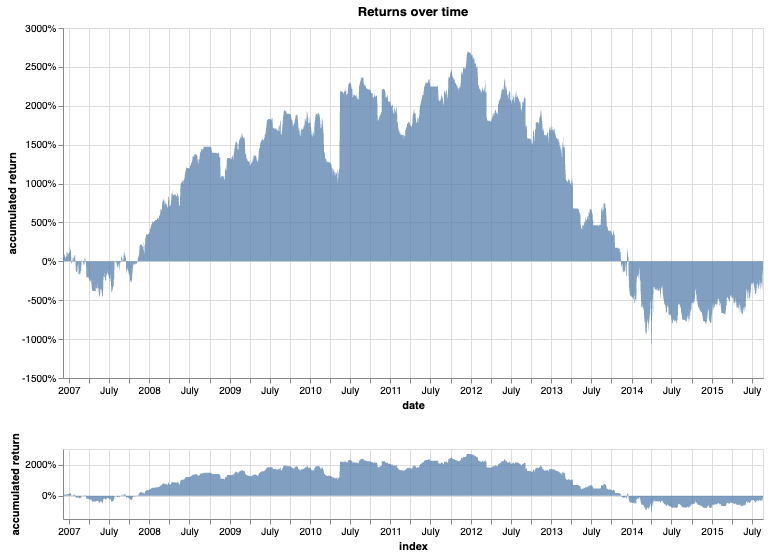

In [10]:
returns_chart(bt.balance)

We now run a [long (ATM) straddle](https://www.investopedia.com/terms/l/longstraddle.asp) 45 DTE. This is the opposite of the previous strategy, where we enter buying the contracts instead of selling, and therefore profit from big movements in the underlying asset's price. 

In [11]:
# Long (ATM) straddle
long_straddle = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.BUY)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= schema.underlying_last * 1.05) & (schema.strike >= schema.underlying_last * 0.95)
leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.BUY)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= schema.underlying_last * 1.05) & (schema.strike >= schema.underlying_last * 0.95)
leg2.exit_filter = (schema.dte <= 2)

long_straddle.add_legs([leg1, leg2])
long_straddle.exit_thresholds = (0.25, 0.25)

In [12]:
bt = Backtest()
bt.strategy = long_straddle
bt.data = data
bt.stop_if_broke = False

In [13]:
bt.run(monthly=False)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:04:42


leg_1                                              \
                contract underlying expiration  type  strike    cost   
0     SXY070120C01350000        SPX 2007-01-20  call  1350.0  7520.0   
1     SXY070120C01340000        SPX 2007-01-20  call  1340.0  7990.0   
2     SXY070120C01345000        SPX 2007-01-20  call  1345.0  7580.0   
3     SXY070120C01355000        SPX 2007-01-20  call  1355.0  7030.0   
4     SXY070217C01350000        SPX 2007-02-17  call  1350.0  8130.0   
...                  ...        ...        ...   ...     ...     ...   
1681  SPX150918C02005000        SPX 2015-09-18  call  2005.0 -8030.0   
1682  SPX150918C02000000        SPX 2015-09-18  call  2000.0 -5810.0   
1683  SPX150918C01995000        SPX 2015-09-18  call  1995.0 -6160.0   
1684  SPX150918C01990000        SPX 2015-09-18  call  1990.0 -6520.0   
1685  SPX150918C02010000        SPX 2015-09-18  call  2010.0 -5120.0   

                              leg_2                                     \
          order            contract underlying expiration type  strike   
0     Order.BTO  SXY070120P01350000        SPX 2007-01-20  put  1350.0   
1     Order.BTO  SXY070120P01340000        SPX 2007-01-20  put  1340.0   
2     Order.BTO  SXY070120P01345000        SPX 2007-01-20  put  1345.0   
3     Order.BTO  SXY070120P01355000        SPX 2007-01-20  put  1355.0   
4     Order.BTO  SXY070217P01350000        SPX 2007-02-17  put  1350.0   
...         ...                 ...        ...        ...  ...     ...   
1681  Order.STC  SPX150918P02005000        SPX 2015-09-18  put  2005.0   
1682  Order.STC  SPX150918P02000000        SPX 2015-09-18  put  2000.0   
1683  Order.STC  SPX150918P01995000        SPX 2015-09-18  put  1995.0   
1684  Order.STC  SPX150918P01990000        SPX 2015-09-18  put  1990.0   
1685  Order.STC  SPX150918P02010000        SPX 2015-09-18  put  2010.0   

                         totals                    
        cost      order    cost    qty       date  
0      470.0  Order.BTO  7990.0  125.0 2006-12-06  
1      570.0  Order.BTO  8560.0  116.0 2006-12-07  
2      550.0  Order.BTO  8130.0  123.0 2006-12-08  
3      510.0  Order.BTO  7540.0  132.0 2006-12-11  
4      580.0  Order.BTO  8710.0  114.0 2006-12-29  
...      ...        ...     ...    ...        ...  
1681 -1360.0  Order.STC -9390.0   79.0 2015-08-19  
1682 -2760.0  Order.STC -8570.0   79.0 2015-08-20  
1683 -2650.0  Order.STC -8810.0   82.0 2015-08-20  
1684 -2530.0  Order.STC -9050.0   81.0 2015-08-20  
1685 -3080.0  Order.STC -8200.0   89.0 2015-08-20  

[1686 rows x 17 columns]

In [14]:
bt.summary()

,Strategy
Total trades,842.000000
Number of wins,298.000000
Number of losses,544.000000
Win %,0.353919
Largest loss,998310.000000
Profit factor,0.547794
Average profit,-98444.020190
Average P&L %,-69.427408
Total P&L %,-8371.902500


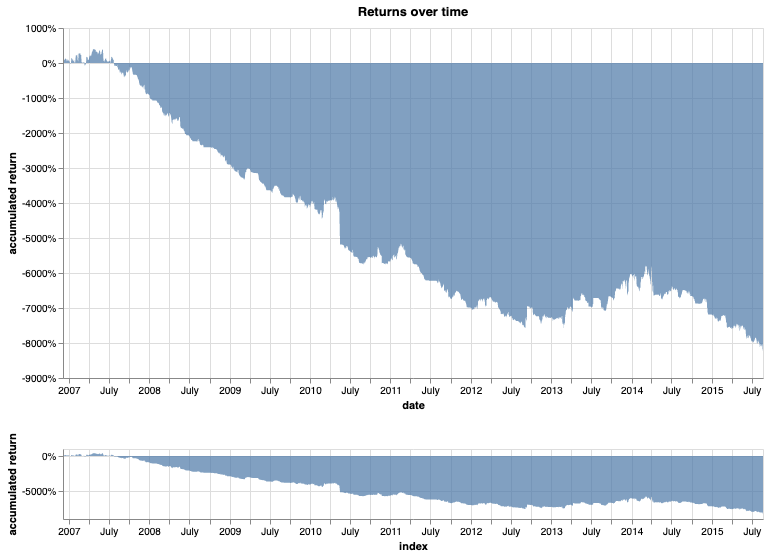

In [15]:
returns_chart(bt.balance)

Finally we run an [iron condor](https://www.investopedia.com/terms/i/ironcondor.asp).

In [16]:
# Iron Condor
iron_condor = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.PUT, direction=Direction.BUY)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= 0.85 * schema.underlying_last)
leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= 0.90 * schema.underlying_last) & (schema.strike <= schema.underlying_last)
leg2.exit_filter = (schema.dte <= 2)

leg3 = StrategyLeg("leg_3", schema, option_type=Type.CALL, direction=Direction.SELL)
leg3.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last) & (schema.strike <= 1.10 * schema.underlying_last)
leg3.exit_filter = (schema.dte <= 2)

leg4 = StrategyLeg("leg_4", schema, option_type=Type.PUT, direction=Direction.BUY)
leg4.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= 1.15 * schema.underlying_last)
leg4.exit_filter = (schema.dte <= 2)


iron_condor.add_legs([leg1, leg2, leg3, leg4])
iron_condor.exit_thresholds = (0.25, 0.25)

In [17]:
bt = Backtest()
bt.strategy = iron_condor
bt.data = data
bt.stop_if_broke = False

In [18]:
bt.run(monthly=False)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:07:18


leg_1                                                     \
               contract underlying expiration type strike  cost      order   
0    SPZ080419P00700000        SPX 2008-04-19  put  700.0  10.0  Order.BTO   
1    SPZ080419P00700000        SPX 2008-04-19  put  700.0  -0.0  Order.STC   
2    SPV081220P00200000        SPX 2008-12-20  put  200.0  55.0  Order.BTO   
3    SPV081220P00200000        SPX 2008-12-20  put  200.0 -10.0  Order.STC   
4    SPV081220P00200000        SPX 2008-12-20  put  200.0  50.0  Order.BTO   
..                  ...        ...        ...  ...    ...   ...        ...   
832  SPX150821P00800000        SPX 2015-08-21  put  800.0  -0.0  Order.STC   
833  SPX150918P00500000        SPX 2015-09-18  put  500.0  -0.0  Order.STC   
834  SPX150918P00600000        SPX 2015-09-18  put  600.0  -0.0  Order.STC   
835  SPX150918P00700000        SPX 2015-09-18  put  700.0  -0.0  Order.STC   
836  SPX150918P00825000        SPX 2015-09-18  put  825.0  -0.0  Order.STC   

                  leg_2                        ...               leg_4  \
               contract underlying expiration  ...            contract   
0    SPT080419P01170000        SPX 2008-04-19  ...  SXM080419P01520000   
1    SPT080419P01170000        SPX 2008-04-19  ...  SXM080419P01520000   
2    SPX081220P00815000        SPX 2008-12-20  ...  SPQ081220P01045000   
3    SPX081220P00815000        SPX 2008-12-20  ...  SPQ081220P01045000   
4    SPX081220P00830000        SPX 2008-12-20  ...  SPQ081220P01060000   
..                  ...        ...        ...  ...                 ...   
832  SPX150821P01845000        SPX 2015-08-21  ...  SPX150821P02600000   
833  SPX150918P01900000        SPX 2015-09-18  ...  SPX150918P02450000   
834  SPX150918P01895000        SPX 2015-09-18  ...  SPX150918P02500000   
835  SPX150918P01890000        SPX 2015-09-18  ...  SPX150918P02550000   
836  SPX150918P01880000        SPX 2015-09-18  ...  SPX150918P02400000   

                                                             totals         \
    underlying expiration type  strike     cost      order     cost    qty   
0          SPX 2008-04-19  put  1520.0  22640.0  Order.BTO  17080.0   58.0   
1          SPX 2008-04-19  put  1520.0     -0.0  Order.STC   5400.0   58.0   
2          SPX 2008-12-20  put  1045.0  15440.0  Order.BTO   5505.0  181.0   
3          SPX 2008-12-20  put  1045.0 -12150.0  Order.STC  -1070.0  181.0   
4          SPX 2008-12-20  put  1060.0  15100.0  Order.BTO   6240.0  160.0   
..         ...        ...  ...     ...      ...        ...      ...    ...   
832        SPX 2015-08-21  put  2600.0 -52120.0  Order.STC -49045.0   19.0   
833        SPX 2015-09-18  put  2450.0 -41660.0  Order.STC -39960.0   31.0   
834        SPX 2015-09-18  put  2500.0 -52480.0  Order.STC -49100.0   27.0   
835        SPX 2015-09-18  put  2550.0 -57480.0  Order.STC -54100.0   23.0   
836        SPX 2015-09-18  put  2400.0 -42490.0  Order.STC -39160.0   34.0   

                
          date  
0   2008-03-07  
1   2008-03-10  
2   2008-11-06  
3   2008-11-07  
4   2008-11-10  
..         ...  
832 2015-08-19  
833 2015-08-20  
834 2015-08-21  
835 2015-08-21  
836 2015-08-21  

[837 rows x 31 columns]

In [19]:
bt.summary()

,Strategy
Total trades,4.170000e+02
Number of wins,1.410000e+02
Number of losses,2.760000e+02
Win %,3.381295e-01
Largest loss,1.303840e+06
Profit factor,5.108696e-01
Average profit,-1.262168e+05
Average P&L %,2.489327e+01
Total P&L %,-5.657955e+03


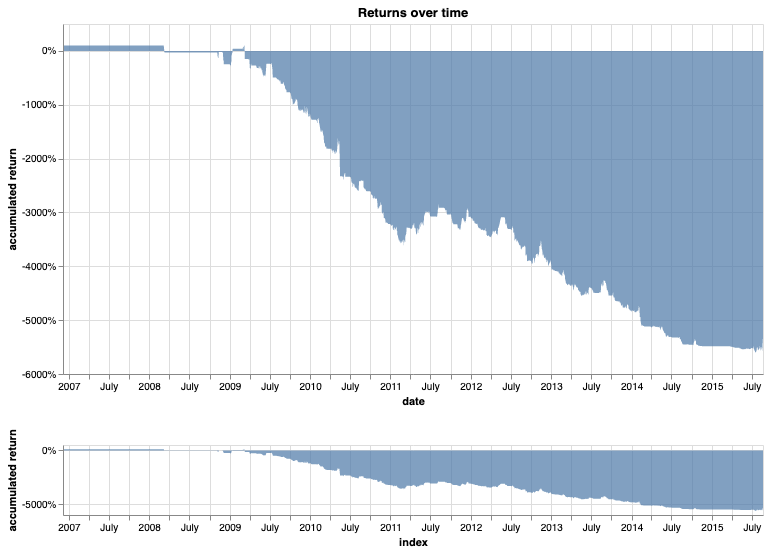

In [20]:
returns_chart(bt.balance)

To run the backtest monthly, use the boolean parameter *monthly* on the *run* method (False by default).

In [21]:
# Short ATM straddle (monthly)
short_straddle_monthly = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.SELL)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte > 60) & (schema.dte <= 90) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg1.exit_filter = (schema.dte <= 60)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte > 60) & (schema.dte <= 90) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg2.exit_filter = (schema.dte <= 60)

short_straddle_monthly.add_legs([leg1, leg2])
# Exit thresholds: none
short_straddle_monthly.exit_thresholds = (float('inf'), float('inf'))

In [22]:
bt = Backtest()
bt.strategy = short_straddle_monthly
bt.data = data
bt.stop_if_broke = False

In [23]:
bt.run(monthly=True)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


leg_1                                               \
               contract underlying expiration  type  strike     cost   
0    SXY070217C01345000        SPX 2007-02-17  call  1345.0  -8530.0   
1    SXY070217C01345000        SPX 2007-02-17  call  1345.0   8200.0   
2    SXY070317C01355000        SPX 2007-03-17  call  1355.0  -7920.0   
3    SXY070317C01355000        SPX 2007-03-17  call  1355.0   9860.0   
4    SXY070421C01375000        SPX 2007-04-21  call  1375.0  -8730.0   
..                  ...        ...        ...   ...     ...      ...   
188  SPX150821C02010000        SPX 2015-08-21  call  2010.0 -11900.0   
189  SPX150821C02010000        SPX 2015-08-21  call  2010.0   8940.0   
190  SPX150918C01975000        SPX 2015-09-18  call  1975.0 -12230.0   
191  SPX150918C01975000        SPX 2015-09-18  call  1975.0  12720.0   
192  SPX151016C02000000        SPX 2015-10-16  call  2000.0 -11020.0   

                             leg_2                                             \
         order            contract underlying expiration type  strike    cost   
0    Order.STO  SXY070217P01345000        SPX 2007-02-17  put  1345.0  -790.0   
1    Order.BTC  SXY070217P01345000        SPX 2007-02-17  put  1345.0   540.0   
2    Order.STO  SXY070317P01355000        SPX 2007-03-17  put  1355.0 -1030.0   
3    Order.BTC  SXY070317P01355000        SPX 2007-03-17  put  1355.0   280.0   
4    Order.STO  SXY070421P01375000        SPX 2007-04-21  put  1375.0  -690.0   
..         ...                 ...        ...        ...  ...     ...     ...   
188  Order.STO  SPX150821P02010000        SPX 2015-08-21  put  2010.0 -2440.0   
189  Order.BTC  SPX150821P02010000        SPX 2015-08-21  put  2010.0  2650.0   
190  Order.STO  SPX150918P01975000        SPX 2015-09-18  put  1975.0 -2810.0   
191  Order.BTC  SPX150918P01975000        SPX 2015-09-18  put  1975.0  1020.0   
192  Order.STO  SPX151016P02000000        SPX 2015-10-16  put  2000.0 -2160.0   

                 totals                    
         order     cost    qty       date  
0    Order.STO  -9320.0  108.0 2006-12-06  
1    Order.BTC   8740.0  108.0 2007-01-03  
2    Order.STO  -8950.0  112.0 2007-01-03  
3    Order.BTC  10140.0  112.0 2007-02-01  
4    Order.STO  -9420.0  107.0 2007-02-01  
..         ...      ...    ...        ...  
188  Order.STO -14340.0   70.0 2015-06-01  
189  Order.BTC  11590.0   70.0 2015-07-01  
190  Order.STO -15040.0   67.0 2015-07-01  
191  Order.BTC  13740.0   67.0 2015-08-03  
192  Order.STO -13180.0   76.0 2015-08-03  

[193 rows x 17 columns]

In [24]:
bt.summary()

,Strategy
Total trades,96.000000
Number of wins,55.000000
Number of losses,41.000000
Win %,0.572917
Largest loss,546120.000000
Profit factor,1.341463
Average profit,26847.187500
Average P&L %,1.398322
Total P&L %,457.901000


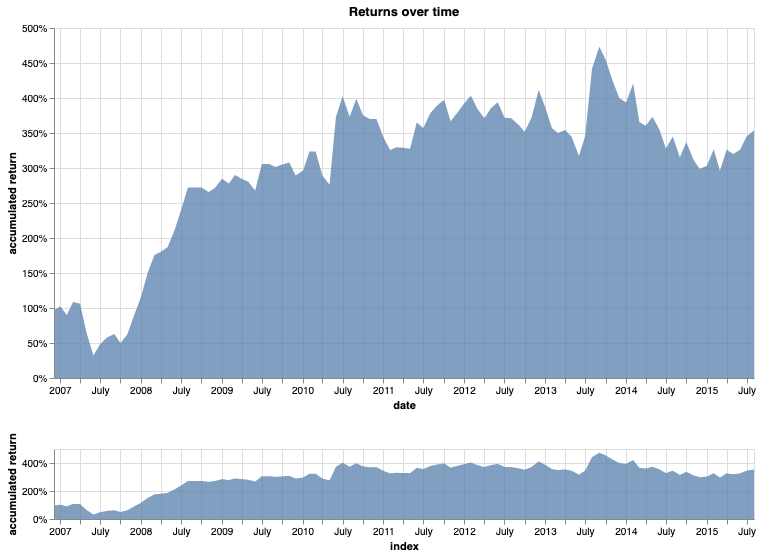

In [25]:
returns_chart(bt.balance)

We also have a class that parametrizes the strangle (long or short). Straddles are a special case of strangles when the *OTM* percentage is (close to) zero.

In [26]:
from backtester.strategy import Strangle

In [32]:
# Long straddle
strangle = Strangle(schema, 'long', 'SPX', dte_entry_range=(61,90), dte_exit=60, otm_pct=0, pct_tolerance=1, exit_thresholds=(float('inf'), float('inf')))

*otm_pct* is how OTM (in percentage) we want the contracts to be. For instance 3 means we pick contracts approximately 3% out of the money. This *approximately* is controlled by the parameter *pct_tolerance*. Its value is the range of *otm_pct*, so if *otm_pct* = 3 and *pct_tolerance* = 1, the contracts we choose are between 2% and 4% OTM. *otm_pct* and *pct_tolerance* are set to 0 and 1 by default.

In [28]:
bt = Backtest()
bt.strategy = strangle
bt.data = data
bt.stop_if_broke = False

In [29]:
bt.run(monthly=True)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


leg_1                                              \
               contract underlying expiration  type  strike    cost   
0    SXZ070217C01400000        SPX 2007-02-17  call  1400.0  4320.0   
1    SXZ070217C01400000        SPX 2007-02-17  call  1400.0 -3450.0   
2    SXZ070317C01405000        SPX 2007-03-17  call  1405.0  4270.0   
3    SXZ070317C01405000        SPX 2007-03-17  call  1405.0 -5120.0   
4    SXZ070421C01435000        SPX 2007-04-21  call  1435.0  4120.0   
..                  ...        ...        ...   ...     ...     ...   
170  SPX150821C02100000        SPX 2015-08-21  call  2100.0  5530.0   
171  SPX150821C02100000        SPX 2015-08-21  call  2100.0 -2690.0   
172  SPX150918C02055000        SPX 2015-09-18  call  2055.0  6620.0   
173  SPX150918C02055000        SPX 2015-09-18  call  2055.0 -5810.0   
174  SPX151016C02075000        SPX 2015-10-16  call  2075.0  5760.0   

                             leg_2                                             \
         order            contract underlying expiration type  strike    cost   
0    Order.BTO  SXZ070217P01400000        SPX 2007-02-17  put  1400.0  1930.0   
1    Order.STC  SXZ070217P01400000        SPX 2007-02-17  put  1400.0 -1330.0   
2    Order.BTO  SXZ070317P01405000        SPX 2007-03-17  put  1405.0  2310.0   
3    Order.STC  SXZ070317P01405000        SPX 2007-03-17  put  1405.0  -610.0   
4    Order.BTO  SXZ070421P01435000        SPX 2007-04-21  put  1435.0  1950.0   
..         ...                 ...        ...        ...  ...     ...     ...   
170  Order.BTO  SPX150821P02100000        SPX 2015-08-21  put  2100.0  5030.0   
171  Order.STC  SPX150821P02100000        SPX 2015-08-21  put  2100.0 -5420.0   
172  Order.BTO  SPX150918P02055000        SPX 2015-09-18  put  2055.0  5210.0   
173  Order.STC  SPX150918P02055000        SPX 2015-09-18  put  2055.0 -2220.0   
174  Order.BTO  SPX151016P02075000        SPX 2015-10-16  put  2075.0  4310.0   

                 totals                    
         order     cost    qty       date  
0    Order.BTO   6250.0  160.0 2006-12-06  
1    Order.STC  -4780.0  160.0 2007-01-03  
2    Order.BTO   6580.0  151.0 2007-01-03  
3    Order.STC  -5730.0  151.0 2007-02-01  
4    Order.BTO   6070.0  164.0 2007-02-01  
..         ...      ...    ...        ...  
170  Order.BTO  10560.0   94.0 2015-06-01  
171  Order.STC  -8110.0   94.0 2015-07-01  
172  Order.BTO  11830.0   84.0 2015-07-01  
173  Order.STC  -8030.0   84.0 2015-08-03  
174  Order.BTO  10070.0   99.0 2015-08-03  

[175 rows x 17 columns]

In [30]:
bt.summary()

,Strategy
Total trades,8.700000e+01
Number of wins,1.200000e+01
Number of losses,7.500000e+01
Win %,1.379310e-01
Largest loss,9.922000e+05
Profit factor,1.600000e-01
Average profit,-1.373849e+05
Average P&L %,-inf
Total P&L %,-1.194942e+03


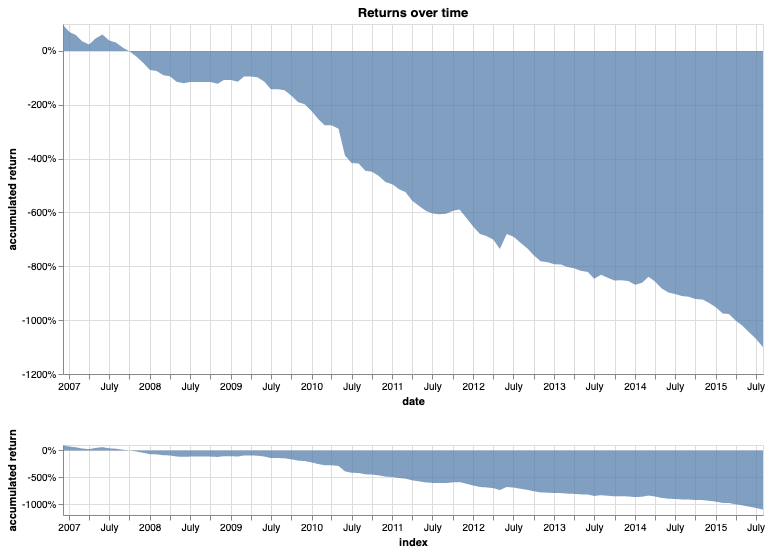

In [31]:
returns_chart(bt.balance)

We now run a monthly short strangle over the entire data with different OTM percentages and plot the capital over time for each of them.

In [33]:
data = HistoricalOptionsData("allspx/options_data_clean_v2.h5", key="/SPX")
schema = data.schema

In [34]:
otm_percentages = [0,3,5,7,10,15,20,25,35]

In [35]:
bt = Backtest()
bt.data = data
bt.stop_if_broke = False
trade_logs = []
summaries = []
balances = []
for otm_pct in otm_percentages:
    strangle = Strangle(schema, 'short', 'SPX', dte_entry_range=(61,90), dte_exit=60, otm_pct=otm_pct, pct_tolerance=1)
    bt.strategy = strangle
    bt.run(monthly=True)
    trade_logs.append(bt.trade_log)
    summaries.append(bt.summary())
    balances.append(bt.balance)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:49
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:50
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:45
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:45
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:44
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:46
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:38
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:35
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:34


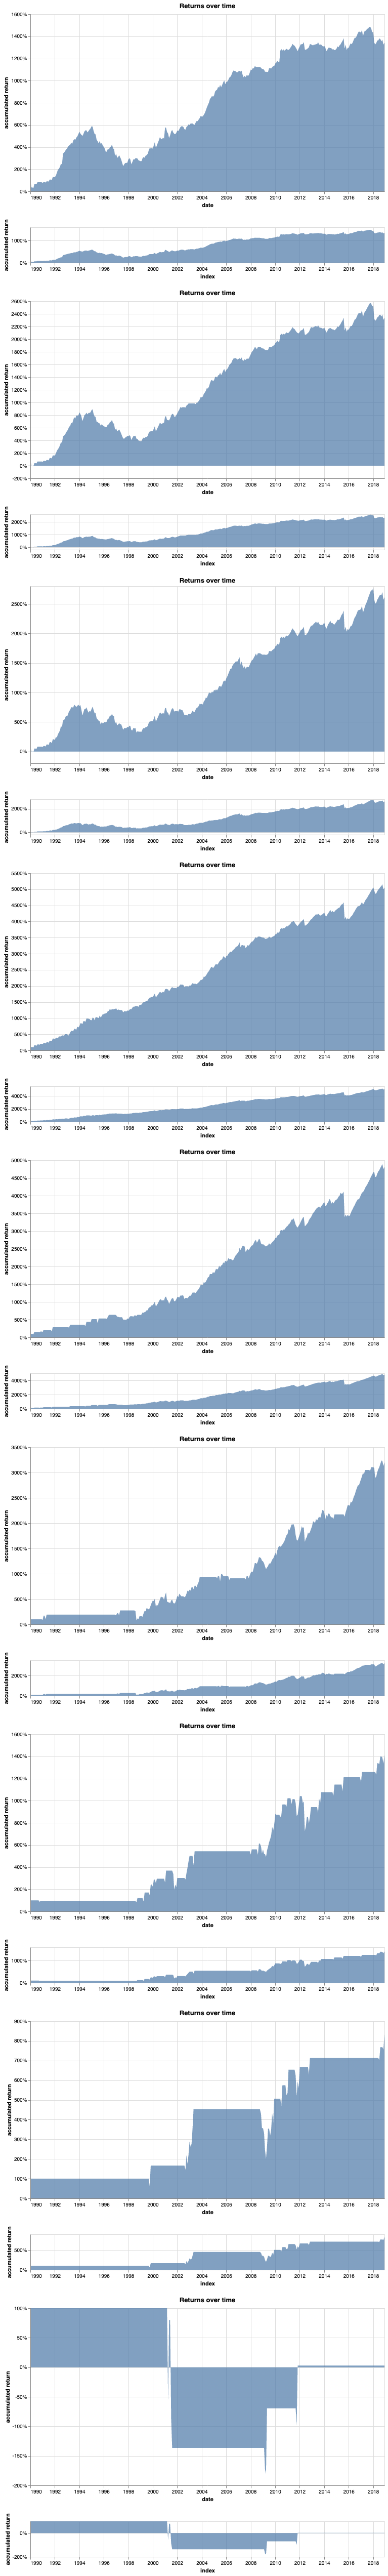

In [36]:
returns_chart(balances[0]) & returns_chart(balances[1]) & returns_chart(balances[2]) & returns_chart(balances[3]) & returns_chart(balances[4]) & returns_chart(balances[5]) & returns_chart(balances[6]) & returns_chart(balances[7]) & returns_chart(balances[8])   

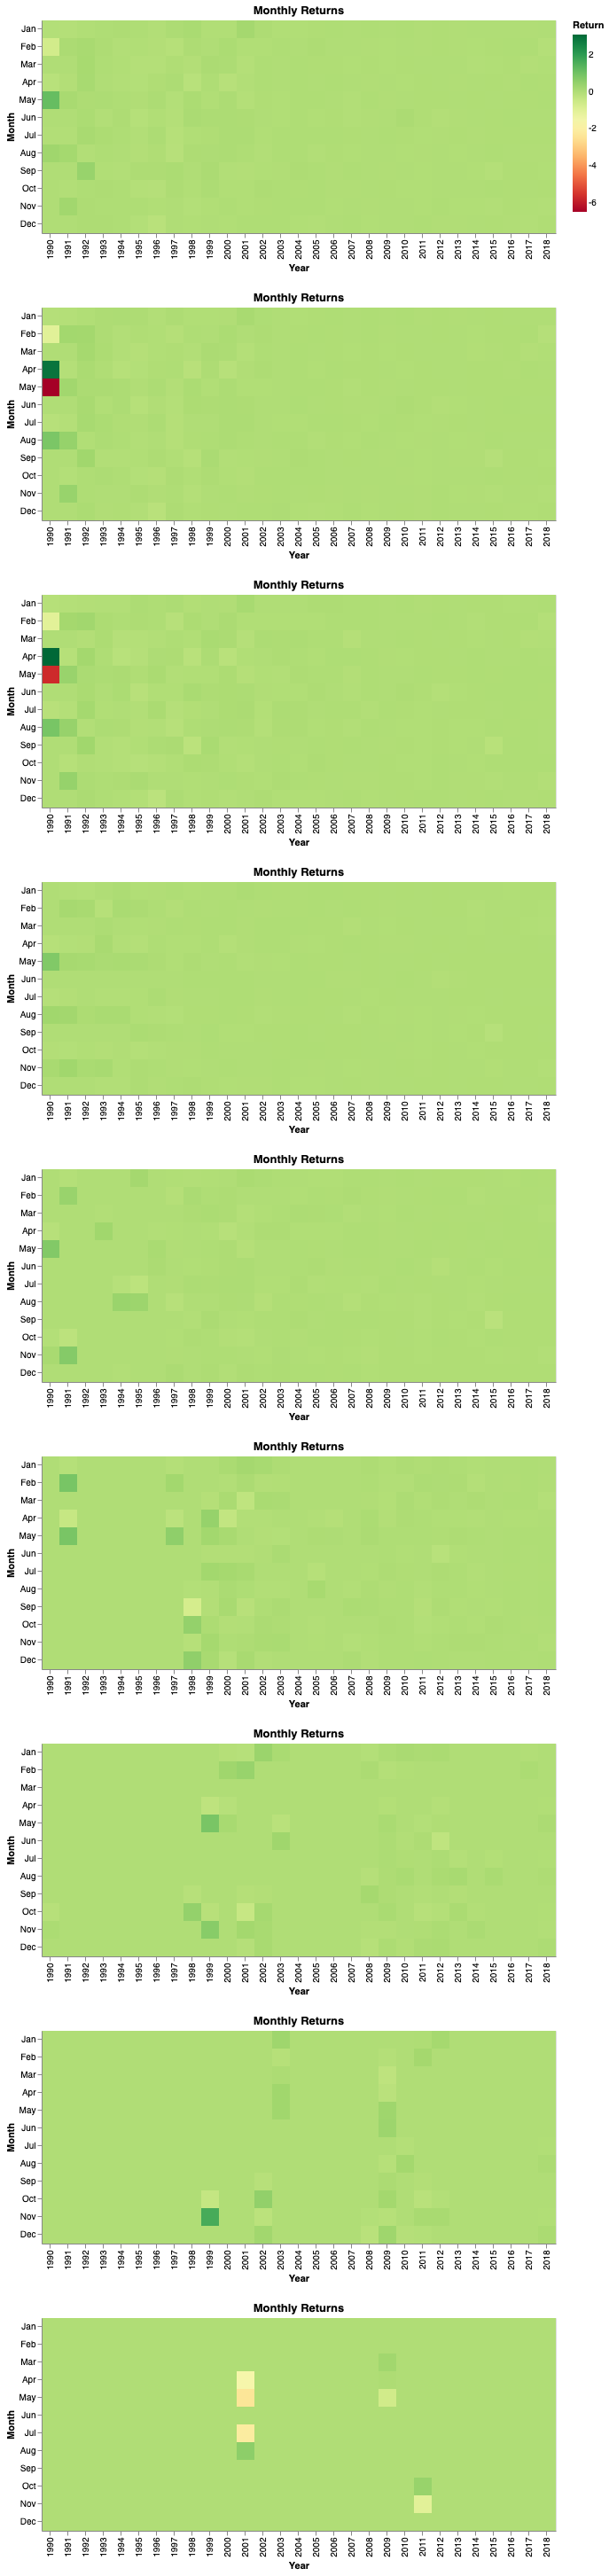

In [37]:
monthly_returns_heatmap(balances[0]) & monthly_returns_heatmap(balances[1]) & monthly_returns_heatmap(balances[2]) & monthly_returns_heatmap(balances[3]) & monthly_returns_heatmap(balances[4]) & monthly_returns_heatmap(balances[5]) & monthly_returns_heatmap(balances[6]) & monthly_returns_heatmap(balances[7]) & monthly_returns_heatmap(balances[8])   

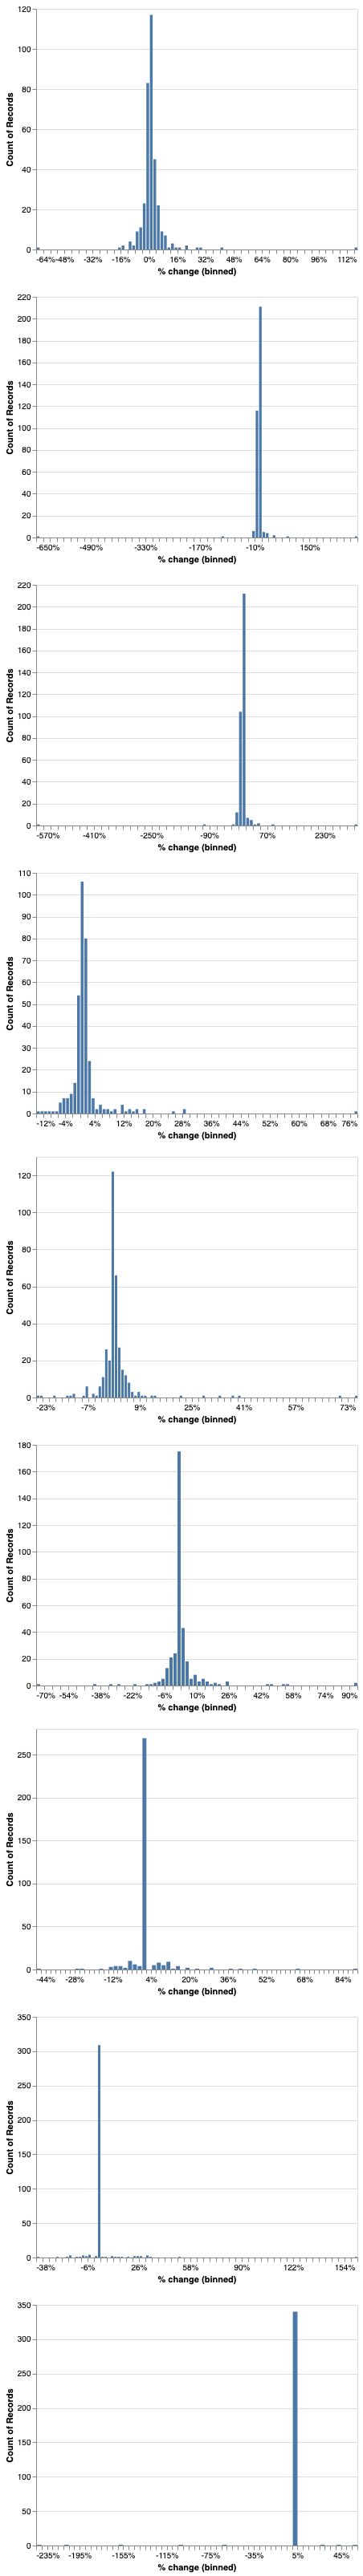

In [38]:
returns_histogram(balances[0]) & returns_histogram(balances[1]) & returns_histogram(balances[2]) & returns_histogram(balances[3]) & returns_histogram(balances[4]) & returns_histogram(balances[5]) & returns_histogram(balances[6]) & returns_histogram(balances[7]) & returns_histogram(balances[8])   